ROB 101: Computational Linear Algebra | University of Michigan, Department of Robotics



Please read carefully. Ask questions if you are unsure.
-------------------------------------------------------



**We use an auto-grader to check your work. If you invent new notation (such as, new variable names) for yourself, you will mess up the auto-grader and receive no points. We will NOT do manual regrades because of failure to use the requested variable names.**



**Do not reinitialize variables and data provided for you. Please just run the cells when information is initialized for you. DO NOT RETYPE IT unless it is in a static cell (a cell that has no run button).**



**Check your answers before submission and read the Canvas assignment instructions.**



In [1]:
using LinearAlgebra, Plots, Random 
gr()

Plots.GRBackend()

### **Overview of Segway Task**



Similar to the cart portion of the project, we will give you a mathematical model of the Segway and some tools for doing computer simulations. A real Segway is three-dimensional and is modeled with nonlinear functions. Here, we are using a simplified model of a Segway where it is constrained to roll along a line, and where the nonlinear functions in its model have been replaced by their linear approximations.



View **segwayImage.png** in attachments (to the right) for a visual reference of the Segway States listed below:



\left[\begin{array}{c} x\_1 \\ x\_2 \\x\_3 \\x\_4 \end{array} \right] = \left[\begin{array}{c} \phi \\ x \\ \dot{\phi} \\\dot{x} \end{array} \right] = \left[\begin{array}{c} \text{ lean angle of the pendulum } \\ \text{ horizontal position of the base } \\ \text{ angular velocity of the pendulum } \\ \text{ horizontal velocity of the base } \end{array} \right]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



**Helpful code for the project:**



In [2]:
function forwardsub(L, b)    
    (nr,nc) = size(L)
    x = Vector{Float64}(undef,nc)
    if minimum(abs.(diag(L))) < 1e-8
        println("L is close to singular. I will not solve this problem")
        return x
    else    
        x[1] = b[1] / L[1,1]
        for i = 2:nc
            x[i]=( b[i] - L[i,1:i-1]' * x[1:i-1] ) / L[i,i]
        end
        return x  
    end
end

#= 
The QR pipeline for minimum norm solution of Ax=b when
the ROWS of A are linearly independent 
(yes, the columns of A' are linearly independent)
=#

function minNormUnderdetermined(A,b)
    F = qr(A')
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    beta = forwardsub(R', b) 
    xStar =Q*beta
    return xStar
end

minNormUnderdetermined (generic function with 1 method)

In [3]:
#= 
Functions for simulating discrete-time versions of ODEs. 
These will be used for a cart 
=#

function simModelNomOpenLoop(A,B,x0,u)
    # given x0 and a control sequence u
    # compute the resulting trajectory
    # for k = 0:length(u)
    # using a perfect model 
    # Assume u is a vector and not a 2d array
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    N = length(u)
    xTraj=[xTraj x0]
    for k = 1:N
        xk = xTraj[:,k]
        uk = u[k]
        xkp1 = A*xk+B*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj
end

function simModelDisturbedOpenLoop(A,B,x0,u)
    # given x0 and a control sequence u
    # compute the resulting trajectory
    # for k = 0:length(u)
    # when the model has unexpected deviations 
    # from its nominal behavior!
    # Assume u is a vector and not a 2d array
    dt=0.1
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    N = length(u)
    xTraj=[xTraj x0]
    for k = 1:N
        xk = xTraj[:,k]
        uk = u[k]
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj
end

function xkPlus1DisturbedCart(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    Anom=A
    d=0.1
    Amud=A+dt*[0 0;0 -d]
    Awind=A+dt*[0 0;0 2*d]
    xkp1 = Array{Float64,2}(undef,rA,1)
    for k = 1:N
        if  abs(xk[1]-3)<1
            xkp1 = Amud*xk+B*uk            
        elseif abs(xk[1]-11)<0.6
            xkp1 = Awind*xk+B*uk
        else
            xkp1 = Anom*xk+B*uk
        end    
    end
    return xkp1
end

function xkPlus1DisturbedSegway(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    d=0.1
    Anom=A
    Dmud=zeros(rA,cA); Dmud[rA,rA]=-d
    Amud=A+dt*Dmud
    Dwind=zeros(rA,cA); Dwind[rA,rA]=2*d
    Awind=A+dt*Dwind
    xkp1 = Array{Float64,2}(undef,rA,1)
    for k = 1:N
        if  abs(xk[2]-10)<1
            xkp1 = Amud*xk+B*uk            
        elseif abs(xk[2]-3)<1.5
            xkp1 = Awind*xk+B*uk
        else
            xkp1 = Anom*xk+B*uk
        end    
    end
    return xkp1
end

function xkPlus1Disturbed(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    if rA==2
         xkp1 = xkPlus1DisturbedCart(A,B,xk,uk,dt)
    else
        xkp1 = xkPlus1DisturbedSegway(A,B,xk,uk,dt)
    end
    return  xkp1   
end

#=
I give you some model data for the Segway and 
a basic open-loop simulator
=#

function SegwayModel()
    #= Original model coorindates are 
    phi=x(1)
    theta=x(2); 
    dphi=x(3);
    dtheta=x(4); 
    
    phi = angle of Segway body
    theta = wheel rotation angle
    
    lateral position = r (theta + phi), 
    where r = wheel radius I
    
    In the end, we are using center of mass (CoM)
    also called, center of gravity
    =#
    r=0.5
    #coordinate change for x position
    # P=[1 0 0 0; r r 0 0; 0 0 1 0; 0 0 r r] 
    P=[1 0 0 0; 1.2 0.5 0 0; 0 0 1 0; 0 0 1.2 0.5]  
    # coordinate change for x-CoM
    Ac = [0 0 1 0; 0 0 0 1; 2.568 0 0 0; -5.020  0 0 0];
    Bc = [0;0;-0.7172;1.6744]
    Id = zeros(4,4) + I
    dt = 0.1
    A = Id + dt*Ac
    B = dt*Bc
    # puts the coordinates as lean angle (radians) and horizonal position (m)
    A=P*A*inv(P); B=P*B 
    return A, B
end
(A,B)=SegwayModel()
(nr,nc) = size(A)

(4, 4)

In [4]:
#=
Generate animations for the Segway.
Your instructors thought it would be much more 
fun if you could see an animation
instead of just looking at plots! 
=#

function rect_rot(w, h, t, theta)
    # w, h: x extend, y extend
    # t: translation
    # theta: rotation in negative z direction
    rot = [cos(theta) sin(theta); -sin(theta) cos(theta)]
    coord = rot*[-w/2 w/2 w/2 -w/2; 0 0 h h] .+ t
    Shape(coord[1, :], coord[2, :])
end

function animSegway(xTraj, fps, end_pause_sec=2)
    # xTraj: 2D array, expect length 4xN, 
    #        N is number of time steps
    # TBD dt sets the frame rate and we only need the position coordinates from xTraj
    if size(xTraj, 1) !== 4
        println("xTraj should have 4 rows. Its number of columns will vary.")
    end
    # geometric paramters for the Segway
    rect_w = 0.1
    rect_h = 2
    lineW = 0.05
    r = 0.5
    end_pause = end_pause_sec*fps
    
    P = [1   0   0   0 
         1.2 0.5 0   0 
         0   0   1   0
         0   0   1.2 0.5]
    xTraj = inv(P)*xTraj
    
    slow_times = 1
    n = size(xTraj, 2)
    if fps < 1
        slow_times = convert(Int64, 1/fps)
    end
    n *= slow_times
    anim = @animate for i ∈ 1:(n+end_pause)
        idx = min(i, n)
        if fps < 1
            idx = convert(Int64, floor((idx-1)/slow_times+1))
        end
        
        phi, theta = xTraj[1, idx], xTraj[2, idx]
        x = (theta+phi)*r
        if x > 3
            x -= 6*floor((x+3)/6)
        end
        center = [x; r]

        # plot the ground in green
        plot(rect_rot(6, 0.1, [0, -0.1], 0), title="Time step: $idx",
             c=:green, xlim = (-3, 3), ylim = (-0.2, 2.8),
             framestyle = :none, size = (600, 300), legend = false)
        
        # plot the circle
        x_cir, y_cir = Plots.unzip(Plots.partialcircle(0, 2π, 100, r))
        # shift the circle to center
        x_cir .+= center[1]; y_cir .+= center[2]
        plot!(Shape(x_cir, y_cir), c = :yellow)
        plot!(rect_rot(lineW, r, center, theta+phi), opacity=.5, c=:blue1)
        
        # plot the rectangle on Segway
        plot!(rect_rot(rect_w, rect_h, center, phi), opacity=.5, c=:blue2)

    end 

    if fps < 1
        gif(anim, "segwayYouMade.gif", fps = 1)
    else
        gif(anim, "segwayYouMade.gif", fps = 15)
    end

end

animSegway (generic function with 2 methods)

❗❗**Pay attention to this next cell!**



┌ Info: Saved animation to d:\CODING\Julia\Project\segwayYouMade.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("d:\\CODING\\Julia\\Project\\segwayYouMade.gif")
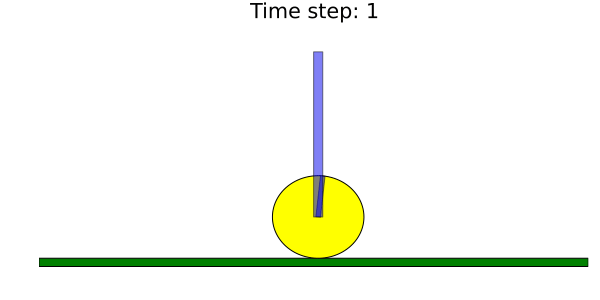

In [5]:
#= 
This cell will lean the Segway a bit 
and then make it stand up. 

Your next task will be to find a control 
sequence by hand to accomplish this.
=#

(A,B)=SegwayModel()

# 5 cm displacement is approximately two inches! 
x0 = [0; .05; 0; 0] 
x_goal=[0.0; 0; 0; 0]
N = 20

#= 
Open-loop control computation
This code will be helpful for 
Segway Tasks 2 & 3
=#
S=A^N
M=Array{Float64,2}(undef,nr,0)
for k=1:N
    M=[A*M B]
end

uControl=minNormUnderdetermined(M,x_goal-S*x0)

titre="Segway"
# nominal open-loop sim
xTrajNom=simModelNomOpenLoop(A,B,x0,uControl)
animSegway(xTrajNom, 15)



---



Segway Task 1
-------------



The purpose here is to see how clever a controller has to be in order to make a Segway stand up! Balance is way harder than pushing a cart around. Controlling a Segway is a bit like balancing a ruler on the palm of your hand; it is not easy!



**Design by hand a control sequence** `u = [u1; u2; u3; u4]` **that will return the Segway to the origin, fully upright, and at rest, when it starts at rest 1 cm to the right. Note, 1 cm is approximately 0.5 inches!**



**Hint****: It is almost possible to do it with a control sequence of the form** `u = [u1; u2; -u2; -u1]`**. Adjust** `u3` **and** `u4` **by + or - some value. Start with numbers between 1 and 20.**



The purpose here is to understand just how hard it is to steer a Segway back to the origin and at rest by hand.



In [7]:
#= 
Declare and adjust your values for u3 and u4 below 

You need to end with norm(xTrajShort[:, end]) < 0.0098  = 9.8 mm,
that is, the norm of the final state is smaller than that of x0!

You started with norm(xTrajShort[:, end]) = 0.01 = 10 mm
=#

# 1 cm displacement = less than 0.5 inches! 
x0 = [0; .01; 0; 0] 

# x = [lean angle; base position; angular velocity; base velocity]
# uk is motor torque at time tk = k*dt

u1 = 286
u2 = -858

-858

In [17]:
# YOUR ANSWER HERE
u3 = 300
u4 = 235

235

Check your `u3` and `u4` here!



xTrajShort[:, end] = [0.004701389440000867, 0.00015058652799993373, 3.552713678800501e-15, -1.1102230246251565e-16]
norm(xTrajShort[:, end]) = 0.004703800481415718
norm(x0) = 0.01

 Nice work!


┌ Info: Saved animation to d:\CODING\Julia\segwayYouMade.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("d:\\CODING\\Julia\\segwayYouMade.gif")
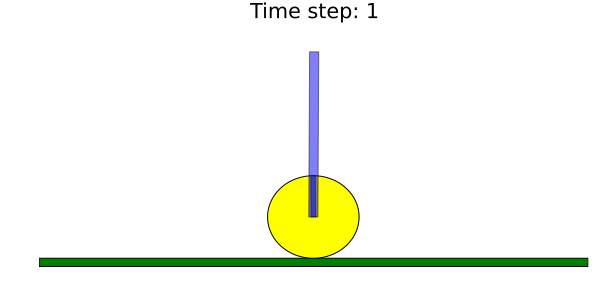

In [51]:
u3 = 850
u4 = -278

uControlShort=[u1;u2;u3;u4]
(A,B)=SegwayModel()
xTrajShort=simModelNomOpenLoop(A,B,x0,uControlShort)

@show xTrajShort[:,end]
@show norm(xTrajShort[:,end])
@show norm(x0)

if  norm(xTrajShort[:,end]) > norm(x0)
    println("\n You ended farther from being at rest at the origin than you started!")
elseif norm(xTrajShort[:,end]) > 0.0098
    println("\n Can you do better? Give it another try!")
    println("\n We will check for norm(xTrajShort[:, end]) < 0.0098")
else
    println("\n Nice work!")
end

# we only plot the final pose here!
animSegway(xTrajShort[:, end], 1, 25)

Segway Task 2
-------------



**Use least squares to find an open-loop control sequence of length N=30 to drive the Segway back to the origin and at rest when it starts from an initial point that is one meter to the right of the origin.** `x0` **and** `xGoal` **are given to you.**



**You must name your control sequence** `uControl` **for the supplied simulation code to work properly. All of the code that you have to write has been used previously in the project.**



We will discover that when "balance" is an issue, feedback control is very challenging. You will see that steering the Segway to a final goal state does not always result in the Segway producing a maneuver that would be acceptable for a rider, even in a perfect world where your Segway does not encounter any disturbances!



In [ ]:
# 1 meter from the goal, at rest (means all velocities are zero), straight up!
x0=[0;1.0;0;0] 
xGoal=[0.0; 0; 0; 0]
N = 30
(A,B)=SegwayModel();

In [ ]:
# YOUR ANSWER HERE


In [ ]:
xTrajNom=simModelNomOpenLoop(A,B,x0,uControl)

# time for plots
dt = 0.1
t=(1:N)*dt

#Plot 1
titre="Segway"
p1=scatter(t,uControl,legend=false, title=titre, color=:black )
xlabel!("Time (sec)");ylabel!("Control Input Signal")
plot!(t,0.0*uControl,linewidth=2, color=:black)
p1

In [ ]:
#Plot 2
p2=plot(xTrajNom[1,:]*180/pi, xTrajNom[2,:], title=titre, color=:green, label = "Open-Loop with No Disturbances")
scatter!([xTrajNom[1,1]*180/pi], [xTrajNom[2,1]], color=:blue, label="Start")
scatter!([xTrajNom[1,end]*180/pi], [xTrajNom[2,end]], color=:red, label="End")
xlabel!("x1 = Lean Angle of Segway Body (degrees)");ylabel!("x2 = Horizontal Position (m)");
p2

Check your `uControl` here!



In [ ]:
#Checking your control sequence
if ( (norm(xTrajNom[:,end]) < 1e-8) & (length(uControl)==30) )
    println("Your control sequence appears to be correct.")
else
    println("Try again.")
end

animSegway(xTrajNom, 15)

**Segway Task 2 Fun Question** (0 points)



Plot 2 shows a maximum lean angle that is a few degrees smaller than 100. Based on this information, the motion control sequence you just designed resulted in a safe motion for the Segway and its rider.



True/False quiz: The statement above is...

Answers:
 - True
- False



Segway Task 3
-------------



This task will use an MPC-style feedback controller.



**Here is some useful code:**



In [ ]:
function xkPlus1Disturbed(xk,uk,dt)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    Anom=A
    d=0.1
    Dmud=zeros(rA,cA); Dmud[4,4]=-d
    Amud=A+dt*Dmud
    Dwind=zeros(rA,cA); Dwind[4,4]=2*d
    Awind=A+dt*Dwind
    xkp1 = Array{Float64,2}(undef,rA,1)
    for k = 1:N
        if  abs(xk[2]-10)<1
            xkp1 = Amud*xk+B*uk            
        elseif abs(xk[2]-3)<1.5
            xkp1 = Awind*xk+B*uk
        else
            xkp1 = Anom*xk+B*uk
        end    
    end
    return xkp1
end

function simModelDisturbed(x0,u)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    # Assume u is a vector and not a 2d array
    xTraj = Array{Float64,2}(undef,rA,0)
    N = length(u)
    xTraj=[xTraj x0]
    for k = 1:N
        xk = xTraj[:,k]
        uk = u[k]
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj
end

function simSegwayMPCbalancePerfectWorld(x0,N,xGoal)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=mySegwayMPCbalanceController(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        # no disturbances added
        xkp1 = A*xk+B*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

function simSegwayMPCbalanceShoves(x0,N,xGoal)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=mySegwayMPCbalanceController(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        if k==100
            xk[3]=1.8
        elseif k==300
            xk[4]=.2
        elseif k==500
            xk=[0;1.1;-0.8;0.0]
        end
        xkp1 = A*xk+B*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

function simSegwayMPCbalance(x0,N,xGoal)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=mySegwayMPCbalanceController(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        # Reality bites
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

**Create an MPC balance controller to bring the Segway to rest at the origin. Your goal is therefore** `xGoal=[0;0;0;0]`**. If your MPC control horizon (**`nConHoriz`**) is short, you will very aggressively move the Segway to its goal and scare the living daylights out of its rider.**



Here is a code skeleton for you to use:



In [ ]:
# Hint: try nConHoriz larger than 20 and smaller than 100 

function mySegwayMPCbalanceController(A,B,xk,xGoal)
 
 ### YOUR CODE HERE! ###
 
 uk=uControl[1]
 return uk
end

Hints:



* N is replaced by the MPC control horizon.
* Go back and look at the pre-work if you are stuck!


In [ ]:
# YOUR ANSWER HERE


**Test 1**: You will first test your controller in the setting of a "perfect world", with the Segway starting one meter to the right of the origin. Make sure that the lean angle does not exceed 30 degrees.



In [ ]:
# 1 meter from the goal, at rest (means all velocities are zero), straight up!
x0=[0;1.0;0;0] 
xGoal=[0.0; 0; 0; 0]

N=200
(xTrajMPC, uTrajMPC) = simSegwayMPCbalancePerfectWorld(x0,N,xGoal)

dt = 0.1
t=(1:N)*dt

titre="Segway Balance"
p1=scatter(t,uTrajMPC',legend=false, title=titre, color=:black )
xlabel!("Time (sec)");ylabel!("Control Input Signal")
plot!(t,0.0*uTrajMPC',linewidth=2, color=:black)
p1

In [ ]:
p2=plot(xTrajMPC[1,:]*180/pi, xTrajMPC[2,:], title=titre, color=:green, label = "MPC with No Disturbances")
scatter!([xTrajMPC[1,1]*180/pi], [xTrajMPC[2,1]], color=:blue, label="start")
scatter!([xTrajMPC[1,end]*180/pi], [xTrajMPC[2,end]], color=:red, label="end")
xlabel!("x1 = Lean Angle of Segway Body (degrees)");ylabel!("x2 = Horizontal Position (m)");
p2

In [ ]:
maxLeanAngle=maximum(abs.(xTrajMPC[1,:]*180/pi))
println("Your maximum lean angle was $maxLeanAngle degrees")

# animate 
animSegway(xTrajMPC, 15)

**Test 2**: Once you have your controller working in this "simple" setting, we will judge you by how well your closed-loop system can withstand "shoves" applied to the Segway and its rider without the Segway's lean angle exceeding that already frightening 30 degrees! ← This is what you’ll be graded on.



In [ ]:
#1 meter from the goal, at rest (means all velocities are zero), straight up!
x0=[0;1.0;0;0] 
xGoal=[0.0; 0; 0; 0]

N=700
(xTrajMPC, uTrajMPC) = simSegwayMPCbalanceShoves(x0,N,xGoal)

maxLeanAngle=maximum(abs.(xTrajMPC[1,:]*180/pi))
if (maxLeanAngle > 35)
    println("Your maximum lean angle was $maxLeanAngle degrees and greatly exceeded the tolerance. Go back and fix your controller")
elseif (maxLeanAngle > 30)
    println("Your maximum lean angle was $maxLeanAngle degrees and while it exceeded the tolerance, it's good enough for full credit")
else
    println("Your maximum lean angle was $maxLeanAngle degrees and you met the specifiction! Bravo!")
end

t=(1:N)*dt
titre="Segway Balance"
p11=scatter(t',uTrajMPC,legend=false, title=titre, color=:black )
xlabel!("Time (sec)");ylabel!("Control Input Signal")
plot!(t',0.0*uTrajMPC,linewidth=2, color=:black)
p11

In [ ]:
t=(1:N+1)*dt
p12=plot(t, xTrajMPC[1,:]*180/pi, title=titre, color=:green, label = " Lean Angle (degrees): MPC with shoves")
plot!(t,0.0*xTrajMPC[1,:],linewidth=2, color=:black)
p12

In [ ]:
p13=plot(t, xTrajMPC[2,:], title=titre, color=:orange, label = " Base Position (m): MPC with shoves")
plot!(t,0.0*xTrajMPC[1,:],linewidth=2, color=:black)
p13

In [ ]:
# animation
animSegway(xTrajMPC, 15)



---



![](https://th.bing.com/th/id/R.4d6499b407bac347f8556ad71240f43a?rik=F5UVHjaTRnhI2g&pid=ImgRaw&r=0)

**You are on your own for Segway Task 4!**
------------------------------------------



### **By completing the previous tasks, you have all of the information you need.**



### **You may not ask for hints on Piazza. Instructional staff will not assist you.**



Segway Task 4
-------------



**Create an MPC-inspired SPEED controller to keep the Segway moving along at 1 meter per second. Your goal is**



****xGoal=\begin{bmatrix} \text{lean angle }= 0 \\ \text{lean velocity }=0\\ \text{velocity of the Segway base }= v^{\rm des}\end{bmatrix}****



**where **v^{\rm des}=1.0****



Very important: `xGoal` does not contain the position of the Segway's base. As you can see above, it only has three components and not four.



The constraints you set up to solve



### uControl = \underset{u \in \mathbb{R}^k, Mu = y}{{\rm arg~~ min}~~~ u^\top u }



must NOT contain the position of the Segway's base. (*Look back at the Pre-Work if you’re confused on how to exclude the Segway’s base*)



The Segway will have to withstand disturbances, of course! We will provide the final simulation environment.



Once again, you cannot have your Segway's lean angle exceeding that frightening value of 30 degrees!



Here is a code skeleton for you to use:



In [ ]:
# Hint: try nConHoriz 5 - 20

function myMPCSegwaySpeedController(A,B,xk,xGoal)

 ### YOUR CODE HERE! ###

 #= 
 This is very similar to Segway Task 3
 the difference is your control horizon (nConHoriz) 
 and the components (C)
 =# 
 
 uk=uControl[1]
 return uk
end

In [ ]:
# YOUR ANSWER HERE


Test 1: No disturbances



In [ ]:
function simSegwayMPCspeed(x0,N,xGoal)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=myMPCSegwaySpeedController(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

x0=[0;0;0;.9]

#=
We gave you the goal
x1Goal x3Goal x4Goal
=#
xGoal = [0;0;1.0] 

# 30 seconds
N=300 

(xTrajMPC, uTrajMPC) = simSegwayMPCspeed(x0,N,xGoal)

maxLeanAngle=maximum(abs.(xTrajMPC[1,:]*180/pi)) + 6

if (maxLeanAngle > 35)
    println("Your maximum lean angle was $maxLeanAngle degrees and exceeded the tolerance. Go back and fix your controller")
else
    println("Your maximum lean angle was $maxLeanAngle degrees and you met the specifiction! Bravo!")
end

titre="Segway"
t=(1:N)*dt
p20=plot(t,uTrajMPC',legend=false, title=titre, color=:black, linewidth=1 )
scatter!(t,uTrajMPC',legend=false, title=titre, color=:black)
xlabel!("Time (sec)");ylabel!("Control Input Signal")
plot!(t,0.0*uTrajMPC',linewidth=2, color=:black)
p20

In [ ]:
p21=scatter(xTrajMPC[2,:], (180/pi)*xTrajMPC[1,:], title=titre, color=:blue, label = "Closed-Loop with disturbances" )
plot!(xTrajMPC[2,:], (180/pi)*xTrajMPC[1,:], color=:blue)
plot!(t,0.0*uTrajMPC',linewidth=2, color=:black)
ylabel!("x1 = Lean Angle (degrees) ");xlabel!("x2 = Position (m)");
p21

In [ ]:
refV=ones(1,N+1)
@show norm(xTrajMPC[4:4,:]-refV)

t=(1:N+1)*dt
p22=plot(t,xTrajMPC[4,:],legend=false, title=titre, color=:red ) 
scatter!(t,refV',legend=false, title=titre, color=:black)
scatter!(t,xTrajMPC[4,:],legend=false, title=titre, color=:red )
xlabel!("Time (sec)");ylabel!("speed")
p22

In [ ]:
animSegway(xTrajMPC, 15)

Test 2: With disturbances



In [ ]:
function simSegwayMPCspeedTest(x0,N,xGoal)
    (A,B)=SegwayModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=myMPCSegwaySpeedController(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        if k==70
            xk[3]=1.8
        elseif k==150
            xk[4]=xk[4]-0.05
        elseif k==200
            xk=xk-8*[0.05;0;-0.2;0.0]
        end
        xkp1 = A*xk+B*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

x0=[0;0;0;.9]
xGoal = [0;0;1.0] 
N=300 
(xTrajMPC, uTrajMPC) = simSegwayMPCspeedTest(x0,N,xGoal)

maxLeanAngle=maximum(abs.(xTrajMPC[1,:]*180/pi))
println("Your maximum lean angle is $maxLeanAngle")

posTraj = xTrajMPC[2:2, :]
maxDisplacemnt = maximum(abs.(posTraj))

if maxDisplacemnt < 1
    T = N*dt
    println("Oh no! How can you roll at 1 m/s for $T seconds and not go anywhere?")
end

velTraj = xTrajMPC[4:4, :]
minVelocity = minimum(velTraj)
if minVelocity < 0
    println("Uh-oh! Your Segway was rolling backward at $minVelocity m/s.")
end


if (maxLeanAngle>30)||( maxDisplacemnt < 1)||(minVelocity<0)
    println("You need to go back and correct your function")
else
    println("Submit the Project and you're done with ROB 101. We wish you well in your other courses.")
end

![]( https://media.giphy.com/media/Srf1W4nnQIb0k/giphy.gif)